# Neural Networks - Representations

### Recap: Feed-forward Neural Network

We have seen how a neural network can be formalized, both algebraically and graphically, and we saw the computational graph abstraction. 

<img src="pics/nn.png" width=300> 

$$NN_{MLP1}(\mathbf{x})=g(\mathbf{xW^1+b^1})\mathbf{W^2}+\mathbf{b^2}$$

<img src="pics/yg-compgraph1.png">



However, what is the input $\textbf{x}$?

After this lecture you should:
* know about distributional similarity
* understand the difference between discrete and continuous/dense feature representations

## Recap: Logistic Regression


Before we go further, lets make a detour and recap: How do we represent a training instance in a traditional classifier?

For instance, recall our example from week 1: training a Logistic Regression classifier for sentiment classification. 

* Describe in words: what were the features we used? I.e., how did we represent a training instance $\textbf{x}$?
* How can you now describe the entire sentiment training data set as a matrix $X$, i.e.,  what are the rows and columns of $X$? $$ X = \{\mathbf{x_1}, ... , \mathbf{x_n}\} $$ 

In [12]:
__author__ = "bplank"
"""
Exercise: sentiment classification with logistic regression

1) Examine the code. What are the features used?
2) What is the distribution of labels in the data?
3) Add code to train and evaluate the classifier. What accuracy do you get? What is weird?
4) How could you improve the representation of the data?
5) Implement cross-validation.

"""
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np

def load_sentiment_sentences_and_labels():
    """
    loads the movie review data
    """
    ## Q1: What are the features used? Q4: How could you improve the representation of the data?
    positive_sentences = [line.strip() for line in open("data/rt-polarity.pos").readlines()]
    negative_sentences = [line.strip() for line in open("data/rt-polarity.neg").readlines()]

    ## Q2: What is the label distribution?
    positive_labels = [1 for sentence in positive_sentences]
    negative_labels = [0 for sentence in negative_sentences]

    sentences = np.concatenate([positive_sentences,negative_sentences], axis=0)
    labels = np.concatenate([positive_labels,negative_labels],axis=0)
    
    # ADD: randomly shuffle data
    seed=12345
    np.random.seed(seed)
    np.random.shuffle(sentences)
    np.random.seed(seed)
    np.random.shuffle(labels)
    return sentences, labels

## read input data
print("load data..")
sentences, labels = load_sentiment_sentences_and_labels()
# Q: What accuracy do you get when you run the code? What is weird? (if we don't shuffle)
print("split data..")
split_point = int(0.75*len(sentences))
X_train, X_test = sentences[:split_point], sentences[split_point:]
y_train, y_test = labels[:split_point], labels[split_point:]

print("#train instances: {} #test instances: {}".format(len(X_train),len(X_test)))
assert(len(X_train)==len(y_train))
assert(len(X_test)==len(y_test))

## Explain to your neighbor, what happens here?
majority_label = Counter(labels).most_common()[0][0]
majority_prediction = [majority_label for label in y_test]

print("vectorize data..")
vectorizer = CountVectorizer()
classifier = Pipeline( [('vec', vectorizer),
                        ('clf', LogisticRegression())] )

### Q2: add code to train and evaluate your classifier
print("train model..")
## your code here:
classifier.fit(X_train, y_train)
##
print("evaluate model..")
## your code here:
y_predicted = classifier.predict(X_test)
###
print("Accuracy:", accuracy_score(y_test, y_predicted))
print("Majority baseline:", accuracy_score(y_test, majority_prediction))


load data..
split data..
#train instances: 7996 #test instances: 2666
vectorize data..
train model..
evaluate model..
Accuracy: 0.752438109527
Majority baseline: 0.491372843211


# Feature representation

Probably the biggest jump when moving from traditional linear models with sparse inputs to deep neural networks is to stop representing each feature as a unique dimension, but instead represent them as **dense vectors** (Goldberg, 2015).

**discrete representation**

$$\mathbf{x}_{cat} = [0,0,0,0,0,0,1] $$
$$\mathbf{x}_{dog} = [0,0,0,0,1,0,0] $$

**similarity** on discrete representations? $$\mathbf{x}_{cat} \wedge \mathbf{x}_{dog} = 0$$

## Representing words

<center>**"You shall know a word by the company it keeps"** (Firth, J. R. 1957:11)</center>

<img src="pics/flødebolle.png">

### "The company it keeps": word co-occurence matrix

We can represent the "company" of a word in terms of a word co-occurence matrix. On the rows we have the words, on the columns their context.

**Contexts** can be of different types, for example:
* entire documents
* paragraphs
* a window around the word

In [228]:
corpus = ["I like cats", "cats like food", "dogs hate cats", "dogs like food", "cats hate dogs"]

In [229]:
vocab = set(np.concatenate([s.split() for s in corpus],0))
print(vocab)

{'like', 'cats', 'dogs', 'food', 'I', 'hate'}


In [238]:
# lets build a co-occurence matrix (now context is entire document)
w2i = {w: i for i,w in enumerate(vocab)}
coocurrence_matrix = np.zeros((len(vocab),len(vocab)))
for sentence in corpus:
    sentence = sentence.split()
    for i, word_i in enumerate(sentence):
        for j, word_j in enumerate(sentence):
            if i!=j:
                coocurrence_matrix[(w2i[word_i],w2i[word_j])] +=1
print(coocurrence_matrix)
print(w2i)

[[ 0.  2.  1.  2.  1.  0.]
 [ 2.  0.  2.  1.  1.  2.]
 [ 1.  2.  0.  1.  0.  2.]
 [ 2.  1.  1.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.]
 [ 0.  2.  2.  0.  0.  0.]]
{'like': 0, 'cats': 1, 'food': 3, 'I': 4, 'hate': 5, 'dogs': 2}


### LSA (Singular Value Decomposition - SVD)

Approximate a matrix $\mathbf{C}$ through a decomposition into three submatrices:

$$\mathbf{C} \approx \mathbf{U \sum V^T}$$

<img src="https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/box2.png">

NB. $=$ should be $\approx$

In [267]:
from numpy import linalg
U, s, V = linalg.svd(coocurrence_matrix)   #alternative:   from sklearn.decomposition import TruncatedSVD

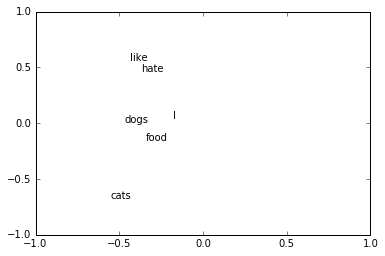

vector for 'like': [-0.43746543  0.55845474 -0.2160615  -0.4472136   0.49799115 -0.04554714]
vector for 'cats': [-0.55174508 -0.67046054  0.07651833 -0.4472136  -0.08461001  0.18178592]


In [268]:
%matplotlib inline
import matplotlib.pyplot as plt
words = list(vocab)
for i, lab in enumerate(vocab):
    plt.text(U[i,0],U[i,1], words[i])
plt.axis([-1, 1, -1, 1])
plt.show()

print("vector for 'like':", U[w2i["like"]])
print("vector for 'cats':", U[w2i["cats"]])


### Similarity

**cosine** similarity 

(it ranges from -1 to 1; is 1 if vectors are the same, 0 if they are independent, and -1 if they are exactly opposite)

<img src="https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/eq1.png">
<img src="https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/vector_example2.png">



**Exercise**: find the most similar words (see similarity.py)

## Directly learning word vectors (embeddings)

* SVD: computation cost scales quadratically with size of co-occurence matrix; difficult to integrate new words
* **Idea**: directly learn word vectors (word2vec)
    * NLP (almost) from Scratch (Collobert & Weston, 2008)
    * word2vec (Mikolov et al, 2013)

### Main idea of word2vec

* instead of capturing co-occurence statistics of words
* **predict context** (surrounding words of every word); in particular, predict words in a window of length $m$ around current word

$o$ is the outside word (context), $c$ is the current center word; 

Maximize the probability of a word in the context ($o$) given the current word $c$:

$$p(o|c) = \frac{exp(u_o^T v_c)}{\sum_{w=1}^W exp(u_w^T v_c)}$$

<img src="http://www.gabormelli.com/RKB/images/a/a6/skip-gram_NNLM_architecture.150216.jpg" width=500>

NB. denominator $\sum$ over all words! In practice, *negative sampling* is used (randomly choose a word which is not in context as a negative sample)

In deep learning we represent words as vectors.

**a) sparse representation vs b) dense representation**  (Figure 1 in Yoav Goldberg's primer)
<img src="pics/sparsevsdense.png">

#### Traditional vs deep learning approach to feature extraction (representations)

The common pipeline of extracting features **for an NLP model with a Neural Network** then becomes:

* extract a set of core linguistic features $f_1,..f_n$
* define a vector **for each feature** (lookup table)
* **combine** vectors of features to get the vector representation for the **instance** $\mathbf{x}$ (**dense representation**)
* use $\mathbf{x}$ as representation for an instance, train the model


    

Lets compare this to our traditional approach - the common pipeline of extracting features for an NLP model is:

* extract a set of core linguistic features $f_1,..f_n$
* define a vector whose length is the total number of features with a 1 at position k if the k-th feature is active; this feature vector represents the **instance** $\mathbf{x}$  (**sparse representation**)
* use $\mathbf{x}$ as representation for an instance, train the model

Now it should be clear why it is called sparse vs dense feature representation.


### How do you combine different feature vector representations?


In an NLP application, $\mathbf{x}$ is usually composed of various embedding vectors.


Following the notation in Goldberg (2015), chapter 4, lets use the function $c(\cdot)$ as **feature combiner** that creates our input embeddings layer.

A common choice for $c$ is **concatenation**:

$\mathbf{x} = c(f_1, f_2, f_3) = [v(f_1); v(f_2); v(f_3)] $

Alternatively, $c$ could be the **sum of the embeddings vector**:

$\mathbf{x} = c(f_1, f_2, f3) = [v(f_1)+v(f_2)+v(f_3)] $

or the **mean**:

$\mathbf{x} = c(f_1, f_2, f3) = [mean(v(f_1),v(f_2),v(f_3))] $

In many papers $v$ is often referred to as the embeddings layer or lookup layer.

#### Our example from before with explicit input representation

For instance, let us explicitly state the input representation. Suppose we use the concatentation operator, then our network above becomes:

<img src="pics/nn.png" width=300> 

since: 
$\mathbf{x} = c(f_1, f_2, f3) = [v(f_1); v(f_2); v(f_3)] $

then: 

$NN_{MLP1}(\mathbf{x})=g(\mathbf{[v(f_1); v(f_2); v(f_3)]W^1+b^1})\mathbf{W^2}+\mathbf{b^2}$



As computational graph:
<img src="pics/yg-compgraph2.png">

The values of the *embedding vectors* (values of the vectors in Fig 1 b)) are treated as model parameters and trained together with the other parameters of the model (weights).

Unrolled (graph with concrete input, expected output, and loss node, Goldberg Figure 3 c):
<img src="pics/yg-compgraph3.png">

### Word Embeddings

So, in deep learning approaches to NLP words are represented as dense vectors. Where do these word vectors (embeddings) come from?

* **randomly initialized** (small numbers around 0) and *trained with the network*
* **off-the-shelf embeddings**: you can also use already trained, available embeddings (e.g. estimated with *word2vec*) and *initialize* the embedding layer of the network with your pretrained (unsupervised) word embeddings
* **task-specific embeddings**: you could also train your embeddings, read them off the network, and use them for another task (or in a multi-task setup, more later)

### Example: animacy classification


### References

* Yoav Goldberg's primer chapter 2 and 5: [A Primer on Neural Network Models for Natural Language Processing](http://arxiv.org/abs/1510.00726)
* Simon Paarlberg's [blog on LSA](https://simonpaarlberg.com/post/latent-semantic-analyses/)
* Richard Socher's [lecture 2](https://www.youtube.com/watch?v=xhHOL3TNyJs)